In [253]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cPickle as cp
import sys
sys.path.append("../../utils")
import os
from plotting_performance_vs_metric import get_measurement_metric, get_performance_metric, average_results_array, median_results_array
from plotting_performance_vs_metric import get_rff_memory_with_model, get_nystrom_memory_with_model, get_cir_rff_memory_with_model
# from plotting_performance_vs_metric import get_rff_memory, get_nystrom_memory, get_cir_rff_memory
import math
from copy import deepcopy
import numpy as np
from plotting_performance_vs_metric import get_results_for_one_precision, plot_figure
from plot_utils import get_colors

### the data folder is called full tuning run but it is the full run after tuning round

In [254]:
def get_performance_list(n_feat_list, general_folder, folder_pattern, seeds, min_metric_best, performance_file_name, do_median, y_reverse=False):
        metric_list_all = []
        for seed in seeds:
            metric_list = []
            for n_feat in n_feat_list:
                subfolder = deepcopy(folder_pattern)
#                 subfolder = subfolder.replace("type_unk", "type_rff")
                subfolder = subfolder.replace("n_fp_feat_unk", "n_fp_feat_" + str(n_feat) )
                subfolder = subfolder.replace("seed_unk", "seed_" + str(seed) )
                folder_name = general_folder + "/" + subfolder
                file_name = performance_file_name
                metric = get_performance_metric(folder_name, file_name, min_best=min_metric_best)
                metric_list.append(metric)
            metric_list_all.append(np.array(deepcopy(metric_list) ) )            
            if y_reverse:
                metric_list_all[-1] = 1.0 - metric_list_all[-1]
        return metric_list_all

In [255]:
def get_metric_list(n_feat_list, general_folder, folder_pattern, seeds, min_metric_best, metric_file_name, metric_name, do_median):
        metric_list_all = []
        for seed in seeds:
            metric_list = []
            for n_feat in n_feat_list:
                subfolder = deepcopy(folder_pattern)
#                 subfolder = subfolder.replace("type_unk", "type_rff")
                subfolder = subfolder.replace("n_fp_feat_unk", "n_fp_feat_" + str(n_feat) )
                subfolder = subfolder.replace("seed_unk", "seed_" + str(seed) )
                folder_name = general_folder + "/" + subfolder
                file_name = metric_file_name
                metric = get_measurement_metric(folder_name, file_name, metric_name)
                metric_list.append(metric)
            metric_list_all.append(np.array(deepcopy(metric_list) ) )
        return metric_list_all

In [256]:
# def get_mem_saving(baseline_perf, baseline_mem, lp_perf, lp_mem, threshold=0.001, min_best=True):
#     lp_mem_saving = []
#     for key in lp_perf.keys():
#         if min_best:
#             idx = np.argmax(lp_perf[key] <= baseline_perf * (1.0 + threshold) )
#             if np.sum(lp_perf[key] <= baseline_perf * (1.0 + threshold) ) == 0:
#                 idx = -1
#         else:
#             idx = np.argmax(lp_perf[key] >= baseline_perf * (1.0 - threshold) )
#             if np.sum(lp_perf[key] >= baseline_perf * (1.0 - threshold) ) == 0:
#                 idx = -1
#         print "baseline / lp ", idx, baseline_mem, lp_mem[key][idx], baseline_perf, lp_perf[key][idx]
#         if idx == -1:
#             lp_mem_saving.append(-1)
#         else:
#             lp_mem_saving.append(baseline_mem /float(lp_mem[key][idx] ) )
#     print "lp memory saving ", np.max(lp_mem_saving)
#     return np.max(lp_mem_saving)

def get_mem_saving(baseline_perf_list, baseline_mem_list, lp_perf_list, lp_mem_list, threshold=0.001, min_best=True, use_median_ref=False):
        lp_mem_saving = []
        if use_median_ref:            
            baseline_perf = np.sort(baseline_perf_list)[len(baseline_perf_list)//2]
            print "median", baseline_perf
        elif min_best:            
            baseline_perf = np.min(baseline_perf_list) 
            print " min ", baseline_perf
        else:            
            baseline_perf = np.max(baseline_perf_list) 
            print " max ", baseline_perf
                        
        for key in lp_perf_list.keys():            
            lp_perf_list[key] = average_results_array(lp_perf_list[key])            
            if min_best:
                idx = np.argmax(lp_perf_list[key] <= baseline_perf * (1.0 + threshold) )
                if np.sum(lp_perf_list[key] <= baseline_perf * (1.0 + threshold) ) == 0:
                    idx = -1
            else:
                idx = np.argmax(lp_perf_list[key] >= baseline_perf * (1.0 - threshold) )
                if np.sum(lp_perf_list[key] >= baseline_perf * (1.0 - threshold) ) == 0:
                    idx = -1
            lp_idx = idx
#             print "ckpt lp ", lp_idx, baseline_perf, lp_perf_list[key]
            if min_best:
                idx = np.argmax(baseline_perf_list <= baseline_perf * (1.0 + threshold) )
                if np.sum(baseline_perf_list <= baseline_perf * (1.0 + threshold) ) == 0:
                    idx = -1
            else:
                idx = np.argmax(baseline_perf_list >= baseline_perf * (1.0 - threshold) )
                if np.sum(baseline_perf_list >= baseline_perf * (1.0 - threshold) ) == 0:
                    idx = -1
            baseline_idx = idx
#             print "ckpt baseline ", baseline_idx, baseline_perf, baseline_perf_list
            if lp_idx == -1:
                lp_mem_saving.append(-1)
            else:
                lp_mem_saving.append(baseline_mem_list[baseline_idx] /float(lp_mem_list[key][lp_idx] ) )
        print "lp memory saving ", np.max(lp_mem_saving)
        return np.max(lp_mem_saving)

In [257]:
def plot_full_run(n_rff_feat, n_nystrom_feat, general_folder_performance, general_folder_metric, folder_pattern, seeds=[1,], 
                  rff_mem_func=None, nystrom_mem_func=None, cir_rff_mem_func=None, min_metric_best=True, 
                  performance_file_name="eval_metric.txt", 
                  metric_file_name="metric_sample_eval.txt", do_median=False, 
                  do_logx_plot=False, do_logy_plot=False, ylim=None, xlim=None, 
                  performance_name="L2 loss", mem_saving_thresh=0.001, y_reverse=False):
    memory_list_rff = np.array( [rff_mem_func(n_feat) for n_feat in n_rff_feat] )
    subfolder_pattern = folder_pattern.replace("type_unk", "type_rff")
    performance_list_rff = get_performance_list(n_rff_feat, general_folder_performance, subfolder_pattern, seeds, 
                                                min_metric_best, performance_file_name, do_median, y_reverse=y_reverse)
#     metric_list_rff = get_metric_list(n_rff_feat, general_folder_metric, subfolder_pattern, seeds, min_metric_best, metric_file_name, metric_name=None, do_median=do_median)
    
    memory_list_nystrom = np.array( [nystrom_mem_func(n_feat) for n_feat in n_nystrom_feat] )
    subfolder_pattern = folder_pattern.replace("type_unk", "type_nystrom")
    performance_list_nystrom = get_performance_list(n_nystrom_feat, general_folder_performance, subfolder_pattern, seeds, 
                                                    min_metric_best, performance_file_name, do_median, y_reverse=y_reverse)
#     metric_list_nystrom = get_metric_list(n_nystrom_feat, general_folder_metric, subfolder_pattern, seeds, min_metric_best, metric_file_name, metric_name=None, do_median=do_median)
    
    memory_list_cir_rff = np.array( [cir_rff_mem_func(n_feat, 32) for n_feat in n_rff_feat] )
    subfolder_pattern = folder_pattern.replace("type_unk", "type_cir_rff")
    subfolder_pattern =  subfolder_pattern.split("_seed_unk")[0] + "_nbit_" + str(64) + "_seed_unk"
    general_folder_performance = deepcopy(general_folder_performance).replace("nystrom_vs_rff_large_exp/full_tuning_run", "lp_rff/full_run")
    performance_list_cir_rff = get_performance_list(n_rff_feat, general_folder_performance, subfolder_pattern, seeds, 
                                                    min_metric_best, performance_file_name, do_median, y_reverse=y_reverse)
#     metric_list_cir_rff = get_metric_list(n_rff_feat, general_folder_metric, subfolder_pattern, seeds, min_metric_best, metric_file_name, metric_name=None, do_median=do_median)
        
    nbit_list = [16, 8, 4, 2, 1]
#     nbit_list = [16, 4, 1]
    lp_cir_rff_perf_dict = {}
    lp_cir_rff_memory_dict = {}
    for nbit in nbit_list:
        memory_list_cir_rff_lp = np.array( [cir_rff_mem_func(n_feat, nbit) for n_feat in n_rff_feat] )
        subfolder_pattern = folder_pattern.replace("type_unk", "type_cir_rff")
        subfolder_pattern =  subfolder_pattern.split("_seed_unk")[0] + "_nbit_" + str(nbit) + "_seed_unk"
        general_folder_performance = deepcopy(general_folder_performance).replace("nystrom_vs_rff_large_exp/full_tuning_run", "lp_rff/full_run")
        performance_list_cir_rff_lp = get_performance_list(n_rff_feat, general_folder_performance, subfolder_pattern, seeds, min_metric_best, 
                                                           performance_file_name, do_median, y_reverse=y_reverse)
        lp_cir_rff_perf_dict[nbit] = performance_list_cir_rff_lp
        lp_cir_rff_memory_dict[nbit] = deepcopy(memory_list_cir_rff_lp)
    
    dataset_name = folder_pattern.split("_")[0]
    
    plt.figure()
    data_list = []
    data_list.append(("fp Nystrom", n_nystrom_feat, performance_list_nystrom) )
    data_list.append(("fp RFF", n_rff_feat, performance_list_rff) )
    data_list.append(("fp cir. RFF", n_rff_feat, performance_list_cir_rff ) )
    
#     print " vs feat rff perf ", performance_list_rff
#     print " vs feat cir rff perf ", performance_list_cir_rff
#     print " vs feat rff mem ", memory_list_rff
#     print " vs feat cir rff mem ", memory_list_cir_rff
     
    for nbit in [8, 4, 1]:
        data_list.append(("lp cir. RFF " + str(nbit) + " bits", n_rff_feat, lp_cir_rff_perf_dict[nbit] ) )
    color_dict = get_colors()
    plot_figure(data_list, color_dict)
    plt.xlabel("Number of features", fontsize=16)
    plt.ylabel("Heldout " + performance_name, fontsize=16)
    plt.legend(fontsize=16, framealpha=0.3)
    if do_logy_plot:
        plt.yscale("log")
    if do_logx_plot:
        plt.xscale("log")
    if ylim is not None:
        plt.ylim(ylim)
    if xlim is not None:
        plt.xlim(xlim)
    plt.tight_layout()
    plt.savefig("./figures/" + dataset_name + "_" + performance_name + "_vs_n_feat.pdf")
    plt.show()
    
    
    plt.figure()
    data_list = []
    data_list.append(("fp Nystrom", memory_list_nystrom, performance_list_nystrom) )
    data_list.append(("fp RFF", memory_list_rff, performance_list_rff) )
    data_list.append(("fp cir. RFF", memory_list_cir_rff, performance_list_cir_rff ) )
    
    
#     print " vs memory rff perf ", performance_list_rff
#     print " vs memory cir rff perf ", performance_list_cir_rff
#     print " vs memory rff mem ", memory_list_rff
#     print " vs memory cir rff mem ", memory_list_cir_rff
    
    for nbit in [8, 4, 1]:
        data_list.append(("lp cir. RFF " + str(nbit) + " bits", lp_cir_rff_memory_dict[nbit], lp_cir_rff_perf_dict[nbit] ) )
    color_dict = get_colors()
    plot_figure(data_list, color_dict)           
    plt.xlabel("Memory", fontsize=16)
    plt.ylabel("Heldout " + performance_name, fontsize=16)
    plt.legend(fontsize=16, framealpha=0.3)
    if do_logy_plot:
        plt.yscale("log")
    if do_logx_plot:
        plt.xscale("log")
    if ylim is not None:
        plt.ylim(ylim)
    if xlim is not None:
        plt.xlim(xlim)
    plt.tight_layout()
    plt.savefig("./figures/" + dataset_name + "_" + performance_name + "_vs_n_memory.pdf")
    plt.show()
    
    # calculate memroy saving
    # note for the memory saving, we need to get 
    if y_reverse:
        memory_saving_metric_min_best = not min_metric_best
    else:
        memory_saving_metric_min_best = min_metric_best
    print "comparing to fp rff best "
    get_mem_saving(baseline_perf_list=average_results_array(deepcopy(performance_list_rff) ), 
                         baseline_mem_list=deepcopy(memory_list_rff), 
                         lp_perf_list=deepcopy(lp_cir_rff_perf_dict), 
                         lp_mem_list=deepcopy(lp_cir_rff_memory_dict), 
                         threshold=mem_saving_thresh, min_best=memory_saving_metric_min_best)
    print "comparing to cir fp rff best "
    get_mem_saving(baseline_perf_list=average_results_array(deepcopy(performance_list_cir_rff) ), 
                         baseline_mem_list=deepcopy(memory_list_cir_rff), 
                         lp_perf_list=deepcopy(lp_cir_rff_perf_dict), 
                         lp_mem_list=deepcopy(lp_cir_rff_memory_dict), 
                         threshold=mem_saving_thresh, min_best=memory_saving_metric_min_best)
    print "comparing to nystrom best "
    get_mem_saving(baseline_perf_list=average_results_array(deepcopy(performance_list_nystrom) ), 
                         baseline_mem_list=deepcopy(memory_list_nystrom), 
                         lp_perf_list=deepcopy(lp_cir_rff_perf_dict), 
                         lp_mem_list=deepcopy(lp_cir_rff_memory_dict), 
                         threshold=mem_saving_thresh, min_best=memory_saving_metric_min_best)
    
    # calculate memroy saving
    print "comparing to fp rff best median"
    get_mem_saving(baseline_perf_list=average_results_array(deepcopy(performance_list_rff) ), 
                         baseline_mem_list=deepcopy(memory_list_rff), 
                         lp_perf_list=deepcopy(lp_cir_rff_perf_dict), 
                         lp_mem_list=deepcopy(lp_cir_rff_memory_dict), 
                         threshold=mem_saving_thresh, min_best=memory_saving_metric_min_best, use_median_ref=True)
    print "comparing to cir fp rff best median"
    get_mem_saving(baseline_perf_list=average_results_array(deepcopy(performance_list_cir_rff) ), 
                         baseline_mem_list=deepcopy(memory_list_cir_rff), 
                         lp_perf_list=deepcopy(lp_cir_rff_perf_dict), 
                         lp_mem_list=deepcopy(lp_cir_rff_memory_dict), 
                         threshold=mem_saving_thresh, min_best=memory_saving_metric_min_best, use_median_ref=True)
    print "comparing to nystrom best median"
    get_mem_saving(baseline_perf_list=average_results_array(deepcopy(performance_list_nystrom) ), 
                         baseline_mem_list=deepcopy(memory_list_nystrom), 
                         lp_perf_list=deepcopy(lp_cir_rff_perf_dict), 
                         lp_mem_list=deepcopy(lp_cir_rff_memory_dict), 
                         threshold=mem_saving_thresh, min_best=memory_saving_metric_min_best, use_median_ref=True)    
    
#     plt.figure()
#     plt.plot(n_rff_feat, np.array(metric_list_rff).astype(np.float64), "-o", label="fp rff")
#     plt.plot(n_rff_feat, np.array(metric_list_cir_rff).astype(np.float64), "-o", label="fp cir rff")
#     plt.plot(n_nystrom_feat, np.array(metric_list_nystrom).astype(np.float64), "-o", label="fp nystrom")
#     plt.title("kernel approx. error vs n feat")
#     plt.legend()
# #     plt.yscale("log")
#     plt.xscale("log")
#     plt.grid()
#     plt.show()
    
#     plt.figure()
#     plt.plot(memory_list_rff, np.array(metric_list_rff).astype(np.float64), "-o", label="fp rff")
#     plt.plot(memory_list_cir_rff, np.array(metric_list_cir_rff).astype(np.float64), "-o", label="fp cir rff")
#     plt.plot(memory_list_nystrom, np.array(metric_list_nystrom).astype(np.float64), "-o", label="fp nystrom")
#     plt.title("kernel approx. error vs n memory")
#     plt.legend()
# #     plt.yscale("log")
#     plt.xscale("log")
#     plt.grid()
#     plt.show()

In [258]:
mem_saving_thresh=0.0001

census heldout sqrt l2


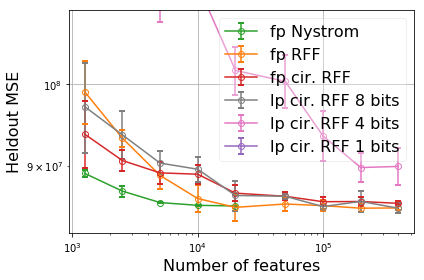

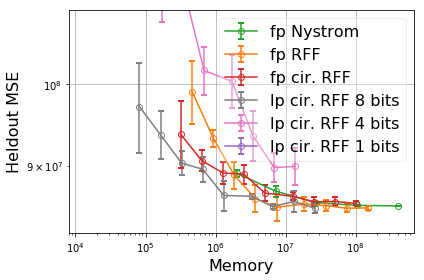

comparing to fp rff best 
 min  85182899.69015567
lp memory saving  2.83206106870229
comparing to cir fp rff best 
 min  85715135.05192329
lp memory saving  15.450381679389313
comparing to nystrom best 
 min  85428864.49040301
lp memory saving  62.19847328244275
comparing to fp rff best median
median 85643422.34786266
lp memory saving  1.132824427480916
comparing to cir fp rff best median
median 86850719.50220478
lp memory saving  3.8625954198473282
comparing to nystrom best median
median 85801194.70463473
lp memory saving  4.099236641221374


In [259]:
print "census heldout sqrt l2"
m = 250
r = 119
c = 1
rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c)
nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c)
cir_rff_mem_func = lambda n, b: get_cir_rff_memory_with_model(n, m, r, b, c)
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run"
general_folder_metric = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run_kernel_approx_error"
subfolder_pattern = "census_type_unk_l2_reg_0_n_fp_feat_unk_opt_sgd_lr_0.5_seed_unk"
nystrom_feat_list = [1250, 2500, 5000, 10000, 20000]
rff_feat_list = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 400000]
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=True, 
            do_logy_plot=True, do_logx_plot=True, ylim=[8.25e7, 1.1e8], 
            performance_name="MSE", mem_saving_thresh=mem_saving_thresh)

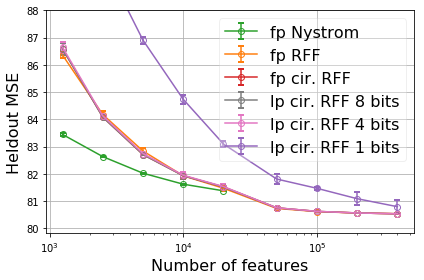

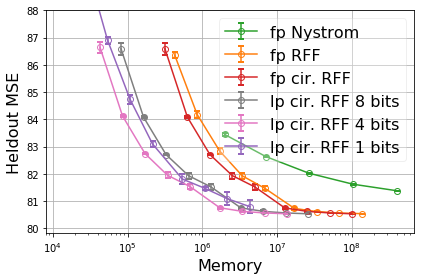

comparing to fp rff best 
 min  80.53403572480472
lp memory saving  9.985401459854014
comparing to cir fp rff best 
 min  80.5291429464301
lp memory saving  7.386861313868613
comparing to nystrom best 
 min  81.37349299706248
lp memory saving  436.85369127516776
comparing to fp rff best median
median 81.46807700324331
lp memory saving  7.34496644295302
comparing to cir fp rff best median
median 81.51448903082185
lp memory saving  5.433557046979866
comparing to nystrom best median
median 82.01975114764461
lp memory saving  77.97080291970804


In [260]:
m = 250
r = 90
c = 1
rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c)
nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c)
cir_rff_mem_func = lambda n, b: get_cir_rff_memory_with_model(n, m, r, b, c)
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run"
general_folder_metric = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run_kernel_approx_error"
subfolder_pattern = "yearpred_type_unk_l2_reg_0_n_fp_feat_unk_opt_sgd_lr_0.5_seed_unk"
nystrom_feat_list = [1250, 2500, 5000, 10000, 20000]
rff_feat_list = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 400000]
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=True, do_logy_plot=False, do_logx_plot=True, 
              performance_name="MSE", ylim=[None, 88.0], mem_saving_thresh=mem_saving_thresh)

covtype heldout accuray


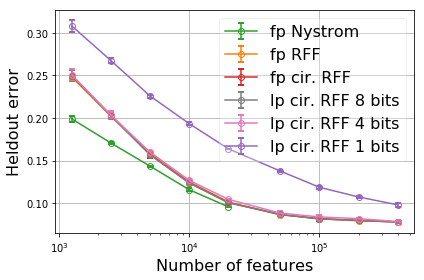

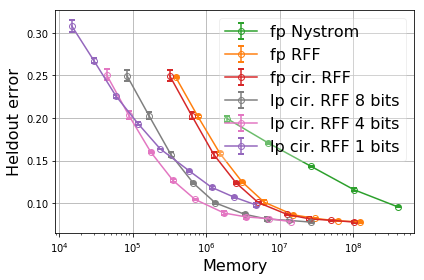

comparing to fp rff best 
 min  0.0783330823347174
lp memory saving  4.616541353383458
comparing to cir fp rff best 
 min  0.07802471260658476
lp memory saving  3.819548872180451
comparing to nystrom best 
 min  0.09578107183580387
lp memory saving  230.422695035461
comparing to fp rff best median
median 0.10133889833121774
lp memory saving  4.616541353383458
comparing to cir fp rff best median
median 0.10095881471282175
lp memory saving  3.819548872180451
comparing to nystrom best median
median 0.14353535136220533
lp memory saving  75.26241134751773


In [261]:
print "covtype heldout accuray"
m = 250
r = 54
c = 2
rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c)
nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c)
cir_rff_mem_func = lambda n, b: get_cir_rff_memory_with_model(n, m, r, b, c)
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run"
general_folder_metric = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run_kernel_approx_error"
subfolder_pattern = "covtype_type_unk_l2_reg_0_n_fp_feat_unk_opt_sgd_lr_50.0_seed_unk"
nystrom_feat_list = [1250, 2500, 5000, 10000, 20000]
rff_feat_list = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 400000]
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3,], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=False,
            do_logy_plot=False, do_logx_plot=True, ylim=[None, None], performance_name="error", 
            mem_saving_thresh=mem_saving_thresh, y_reverse=True)

In [262]:
# print "covtype heldout cross entropy"
# m = 250
# r = 54
# c = 2
# rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c)
# nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c)
# cir_rff_mem_func = lambda n, b: get_cir_rff_memory_with_model(n, m, r, b, c)
# general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run"
# general_folder_metric = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run_kernel_approx_error"
# subfolder_pattern = "covtype_type_unk_l2_reg_0_n_fp_feat_unk_opt_sgd_lr_50.0_seed_unk"
# nystrom_feat_list = [1250, 2500, 5000, 10000, 20000]
# rff_feat_list = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 400000]
# plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3,], 
#             rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
#             cir_rff_mem_func=cir_rff_mem_func, min_metric_best=True, performance_file_name="monitor_signal.txt",
#             do_logy_plot=False, do_logx_plot=True, performance_name="cross_entropy", mem_saving_thresh=mem_saving_thresh)

timit heldout accuracy


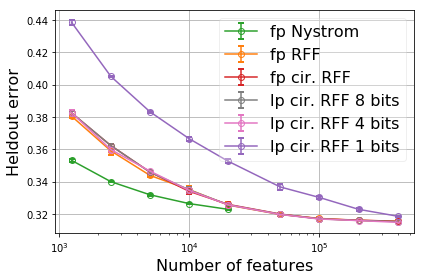

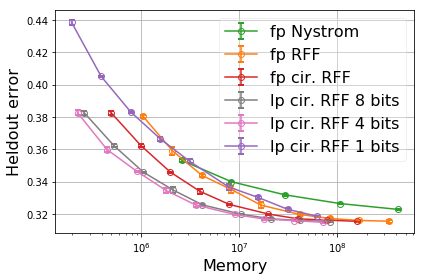

comparing to fp rff best 
 min  0.31548320695895243
lp memory saving  5.090356871678056
comparing to cir fp rff best 
 min  0.3153880352896549
lp memory saving  2.4236902050113893
comparing to nystrom best 
 min  0.32279646994682626
lp memory saving  50.6290053151101
comparing to fp rff best median
median 0.32541912923360977
lp memory saving  2.0361427486712227
comparing to cir fp rff best median
median 0.32584060376907004
lp memory saving  2.2135922330097086
comparing to nystrom best median
median 0.33181330581512497
lp memory saving  8.86408504176158


In [263]:
print "timit heldout accuracy"
m = 250
r = 440
c = 147
rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c)
nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c)
cir_rff_mem_func = lambda n, b: get_cir_rff_memory_with_model(n, m, r, b, c)
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run"
general_folder_metric = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run_kernel_approx_error"
subfolder_pattern = "timit_type_unk_l2_reg_0_n_fp_feat_unk_opt_sgd_lr_100.0_seed_unk"
nystrom_feat_list = [1250, 2500, 5000, 10000, 20000]
rff_feat_list = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 400000]
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=False,
            do_logy_plot=False, do_logx_plot=True, performance_name="error", 
            mem_saving_thresh=mem_saving_thresh, y_reverse=True)

In [252]:
# print "timit heldout cross entropy"
# m = 250
# r = 440
# c = 147
# rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c)
# nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c)
# cir_rff_mem_func = lambda n, b: get_cir_rff_memory_with_model(n, m, r, b, c)
# general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run"
# general_folder_metric = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run_kernel_approx_error"
# subfolder_pattern = "timit_type_unk_l2_reg_0_n_fp_feat_unk_opt_sgd_lr_100.0_seed_unk"
# nystrom_feat_list = [1250, 2500, 5000, 10000, 20000]
# rff_feat_list = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 400000]
# plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3], 
#             rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func,
#             cir_rff_mem_func=cir_rff_mem_func, min_metric_best=True, performance_file_name="monitor_signal.txt",
#             do_logy_plot=False, do_logx_plot=True, performance_name="cross_entropy", mem_saving_thresh=mem_saving_thresh)